In [4]:
!pip install tensorflow_io

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers import Input, concatenate, add
import tensorflow.keras.backend as K

2024-03-21 08:14:03.277149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 08:14:03.277289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 08:14:03.441862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("on TPU")
except:
    print("not on TPU")
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

not on TPU
REPLICAS:  2


In [7]:
IMG_SIZE = (256,256)
CHANNELS = 3
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# [MRI Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)
I use "LGG Segmentation Dataset" 
Dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.

The images were obtained from The Cancer Imaging Archive (TCIA).

They correspond to 110 patients(total 7858 image) included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

In [8]:
mask_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

In [9]:
empty_masks = []
non_empty_masks = []

for mask_path in tqdm(mask_paths):
    mask = np.array(Image.open(mask_path))
    if (mask == 0).all():
        empty_masks.append(mask_path)
    else:
        non_empty_masks.append(mask_path)

  0%|          | 0/3929 [00:00<?, ?it/s]

In [10]:
print(len(non_empty_masks))
print(len(empty_masks))

1373
2556


### select all data with non empty mask and 200 with empty mask data for train

In [11]:
mask_paths = non_empty_masks + [empty_masks[idx] for idx in np.random.choice(len(empty_masks), 200)]
np.random.shuffle(mask_paths)
image_paths = [mask_path.replace('_mask', '') for mask_path in mask_paths]
val_image_paths, val_mask_paths = image_paths[1300:], mask_paths[1300:]
image_paths, mask_paths = image_paths[:1300], mask_paths[:1300]


In [42]:
not_ = []
for img_path in tqdm(image_paths):
    image = tf.io.read_file(img_path)
    image = tfio.experimental.image.decode_tiff(image)
    if not (np.array(image)[:,:,3] == 255).all():
        print(img_path)
        not_.append(img_path)
print(len(not_))

  0%|          | 0/1300 [00:00<?, ?it/s]

0


### Create dataloader and augument data

In [12]:
def load_images(img_path, mask_path):
    image = tf.io.read_file(img_path)
    image = tfio.experimental.image.decode_tiff(image)

    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)
    # tiff have 4 dimesions with last dimesion is empty so we only need fist 3 channels
    return image[:,:,:3], mask[:,:,:1]

def random_flip(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

def random_rotate(image, mask):
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    return image, mask

def random_contrast(image, mask):
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image, mask

def normalize_image(image):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    image = tf.image.resize(image,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.image.resize(mask,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image - 127.5) / 127.5
    mask = (mask - 127.5) / 127.5
    return image, mask

def rescale_image(image, mask):
    image = tf.image.convert_image_dtype(image, tf.float32) # Rescale to [0, 1]
    image = tf.image.resize(image,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, mask

@tf.function
def create_train_dataset(image, mask, is_normalize = False, batch_size = 12, cache = False):
    dataset = tf.data.Dataset.from_tensor_slices((image, mask))
#     dataset = tf.data.TFRecordDataset(dataset)
    options = tf.data.Options()
    options.deterministic = False
    dataset = dataset.with_options(options)
    dataset = dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(2) # Repeat before apply transform function is equal with data augument.
    dataset = dataset.map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(random_rotate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(random_contrast, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_normalize:
        print('Dataset images will normalize to [-1, 1]')
        dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        print('Dataset images will rescale to [0, 1]')
        dataset = dataset.map(rescale_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=True)
    if cache:
        return dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    else:
        return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
def val_image(img_path, mask_path):
    image = tf.image.convert_image_dtype(img_path, tf.float32)
    image = tf.image.resize(image,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    mask = tf.image.convert_image_dtype(mask_path, tf.float32)
    mask = tf.image.resize(mask,[*IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, mask

def create_val_dataset(image, mask, batch_size = 1):
    val_dataset = tf.data.Dataset.from_tensor_slices((image, mask))
    options = tf.data.Options()
    options.deterministic = False
    val_dataset = val_dataset.with_options(options)
    val_dataset = val_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(val_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_batch_size = batch_size * strategy.num_replicas_in_sync
    val_dataset = val_dataset.batch(val_batch_size, drop_remainder=True).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return val_dataset

In [14]:
with strategy.scope():
    dataset = create_train_dataset(image_paths, mask_paths, is_normalize = False, batch_size = GLOBAL_BATCH_SIZE, cache = True)
    val_dataset = create_val_dataset(val_image_paths, val_mask_paths, batch_size = 1)
    options = tf.distribute.InputOptions(experimental_fetch_to_device=False)
    dataset = strategy.experimental_distribute_dataset(dataset, options)
    val_dataset = strategy.experimental_distribute_dataset(val_dataset, options)
    test_dataset = create_val_dataset(val_image_paths, val_mask_paths, batch_size = 1)

Dataset images will rescale to [0, 1]


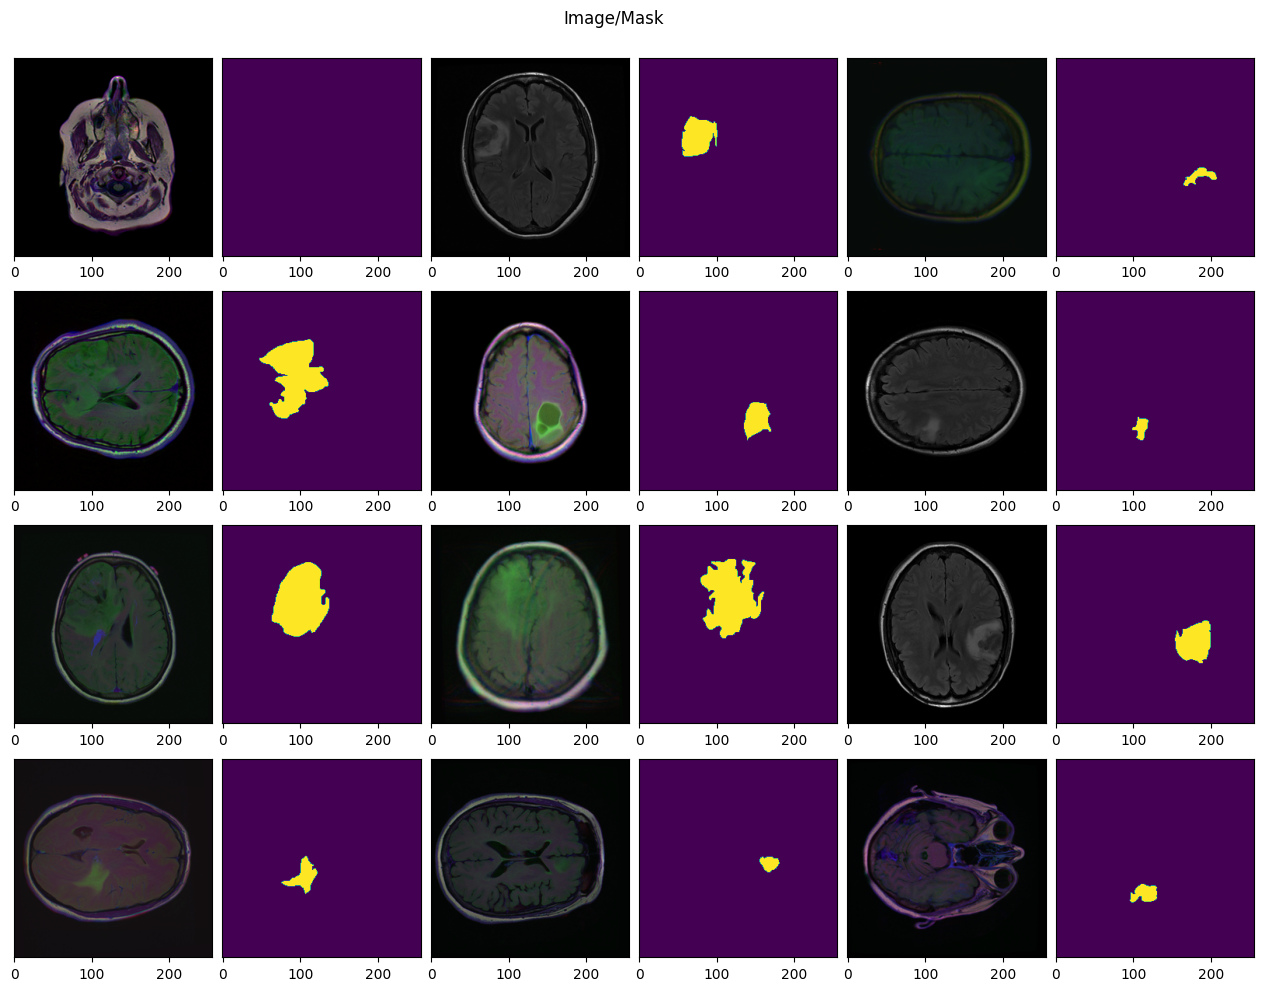

In [106]:
# Check image
sample = next(iter(dataset))
img = sample[0].values
mask = sample[1].values

fig, ax = plt.subplots(4,6, figsize = (16,4*3))
ax = ax.flatten()
for i in range(4*3):
    ax[2*i].imshow(img[0][i])
    ax[2*i].set_yticks([])
    ax[2*i+1].imshow(mask[0][i])
    ax[2*i+1].set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle('Image/Mask', y = 0.91)
plt.show()

### Compute metric between the predicted segmentation and the ground truth

In [15]:

@tf.function
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 1
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

tf.function
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

tf.function
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

@tf.function
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

@tf.function
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    jaccard_coef = (intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + 1)
    return jaccard_coef

@tf.function
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### Build U-Net model

In [61]:
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal', dropout=0.1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
    return conv

def build_model():
    inputs = tf.keras.layers.Input((*IMG_SIZE, CHANNELS))

    # Contracting Path
    c1 = conv_block(inputs, 16)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, dropout = 0.2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, dropout = 0.2)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256, dropout=0.3)

    # Expansive Path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = tf.keras.layers.concatenate([u6, c4])
    c6 = conv_block(c6, 128, dropout = 0.2)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.concatenate([u7, c3])
    c7 = conv_block(c7, 64, dropout = 0.2)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.concatenate([u8, c2])
    c8 = conv_block(c8, 32)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.concatenate([u9, c1])
    c9 = conv_block(c9, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

with strategy.scope():
    lr = 1e-3
    # decay_rate = lr/EPOCHS

    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#                   loss='binary_crossentropy',
                  loss=dice_loss,
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=2),
                         dice_coef, precision, sensitivity, specificity],
#                  steps_per_execution = 10
                 )
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_13[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_15[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_17[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ dropout_18[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
with strategy.scope():
    checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_model.keras',
                                                      verbose=1,
                                                      save_freq = 400)

    callbacks = [checkpointer]
EPOCHS = 30
history = model.fit(dataset, validation_data=val_dataset, epochs=30, callbacks=callbacks)

Epoch 1/30


2024-03-21 08:15:03.084099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_380/cond/StatefulPartitionedCall/functional_1_1/dropout_1_2/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711008912.896692      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 589ms/step - dice_coef: 0.1515 - loss: 1.8241 - mean_io_u: 0.9632 - precision: 0.2006 - sensitivity: 0.9273 - specificity: 1.6367 - val_dice_coef: 0.4092 - val_loss: 0.5908 - val_mean_io_u: 0.5011 - val_precision: 0.4693 - val_sensitivity: 0.4492 - val_specificity: 0.9878
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step - dice_coef: 0.5484 - loss: 1.4272 - mean_io_u: 1.0813 - precision: 0.5743 - sensitivity: 0.5525 - specificity: 1.9633 - val_dice_coef: 0.4490 - val_loss: 0.5510 - val_mean_io_u: 0.5450 - val_precision: 0.5121 - val_sensitivity: 0.3399 - val_specificity: 0.9963
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - dice_coef: 0.5468 - loss: 1.4288 - mean_io_u: 1.1101 - precision: 0.5940 - sensitivity: 0.5490 - specificity: 1.9633 - val_dice_coef: 0.4887 - val_loss: 0.5113 - val_mean_io_u: 0.6005 - val_precision: 0.5016 - val_sensitivity: 0.4437 - val_specificity: 0.9917
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - dice_coef: 

### Predict on Val dataset

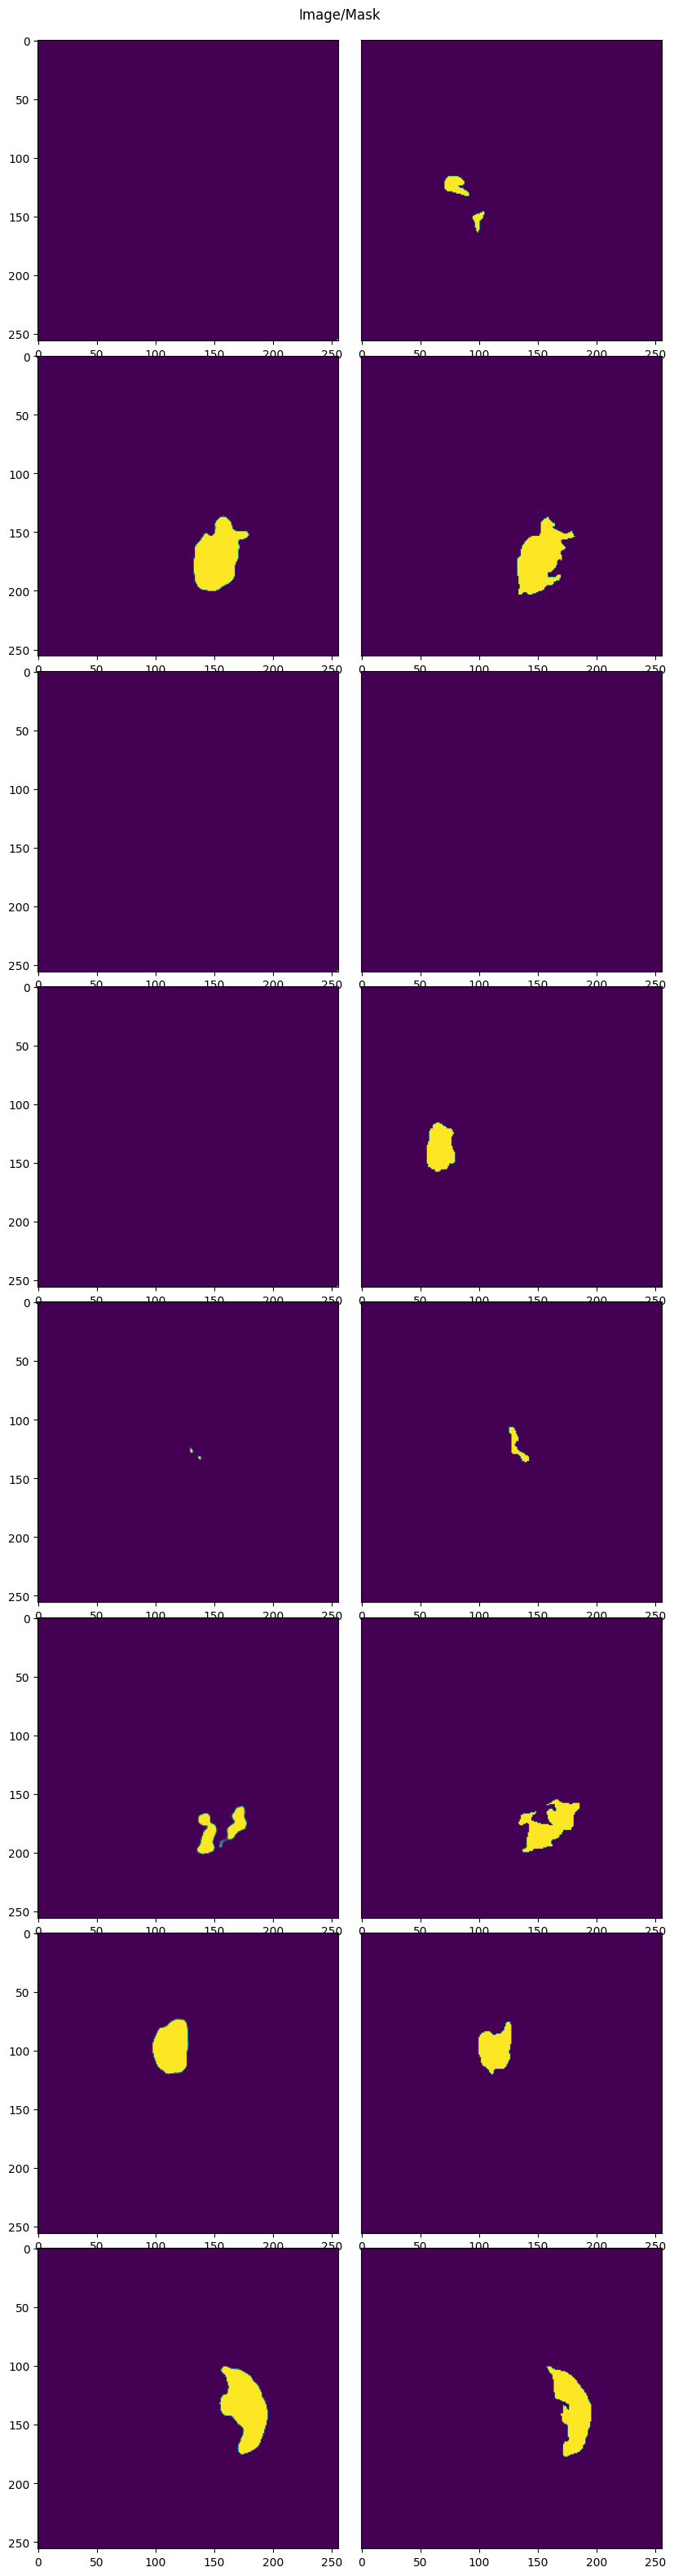

In [60]:
# model.load_weights('/kaggle/working/unet_model.keras')

iter_val_dataset = iter(val_dataset)

fig, ax = plt.subplots(8,2, figsize = (10,40))
ax = ax.flatten()
for i in range(4*2):
    pair = next(iter_val_dataset)
    img = pair[0].values
    mask = pair[1].values
    ax[2*i].imshow(model(img[0])[0])
#     ax[2*i].set_yticks([])
    ax[2*i+1].imshow(mask[0][0])
    ax[2*i+1].set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle('Image/Mask', y = 0.89)
plt.show()

(2, 256, 256, 3)


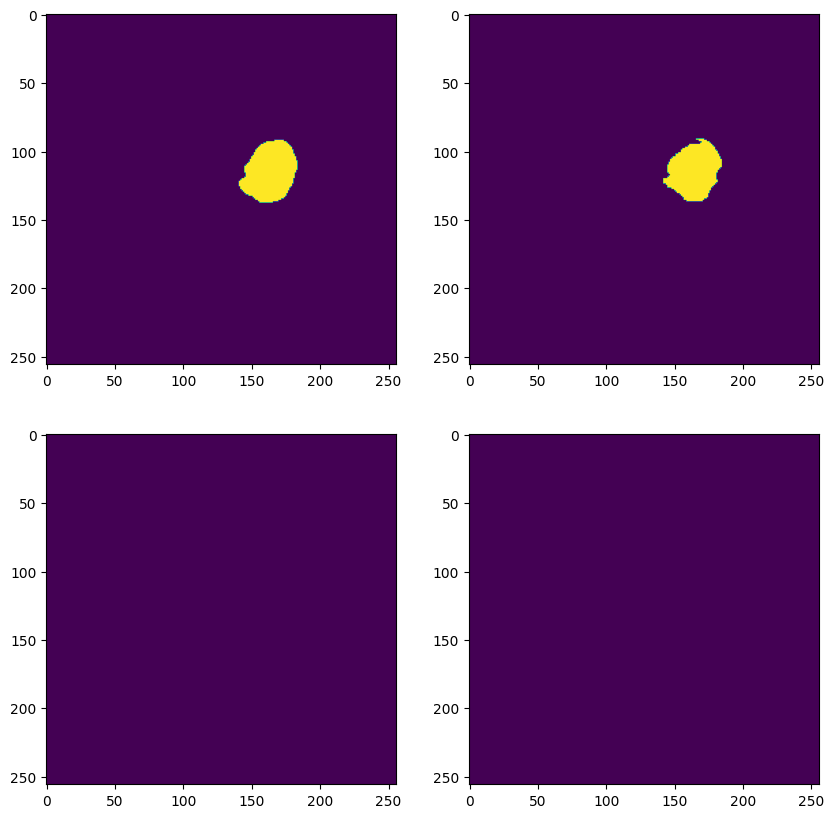

(2, 256, 256, 3)


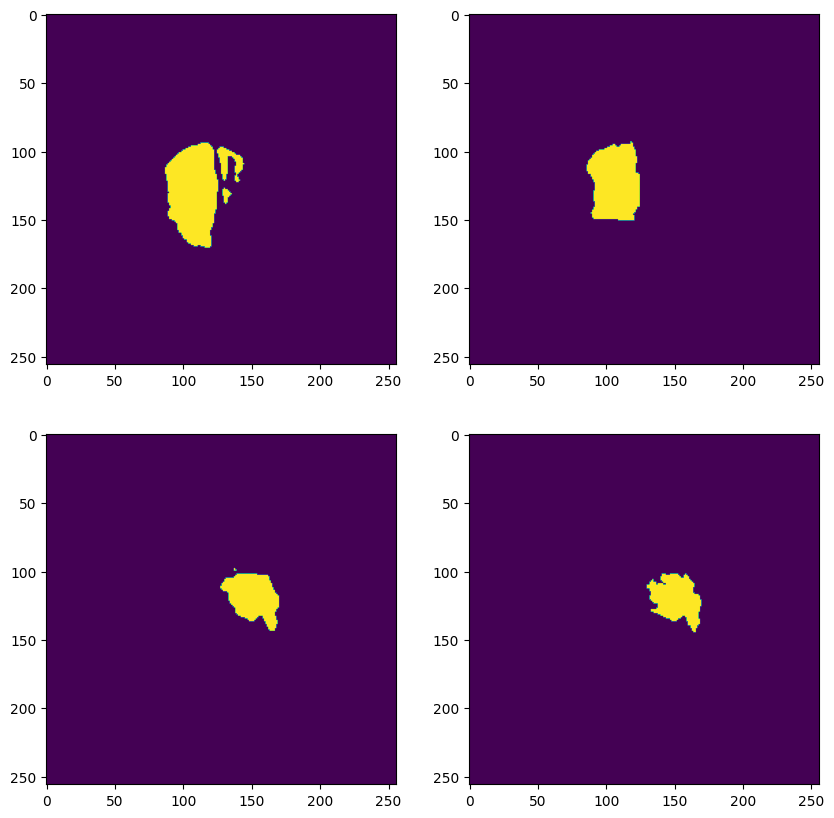

(2, 256, 256, 3)


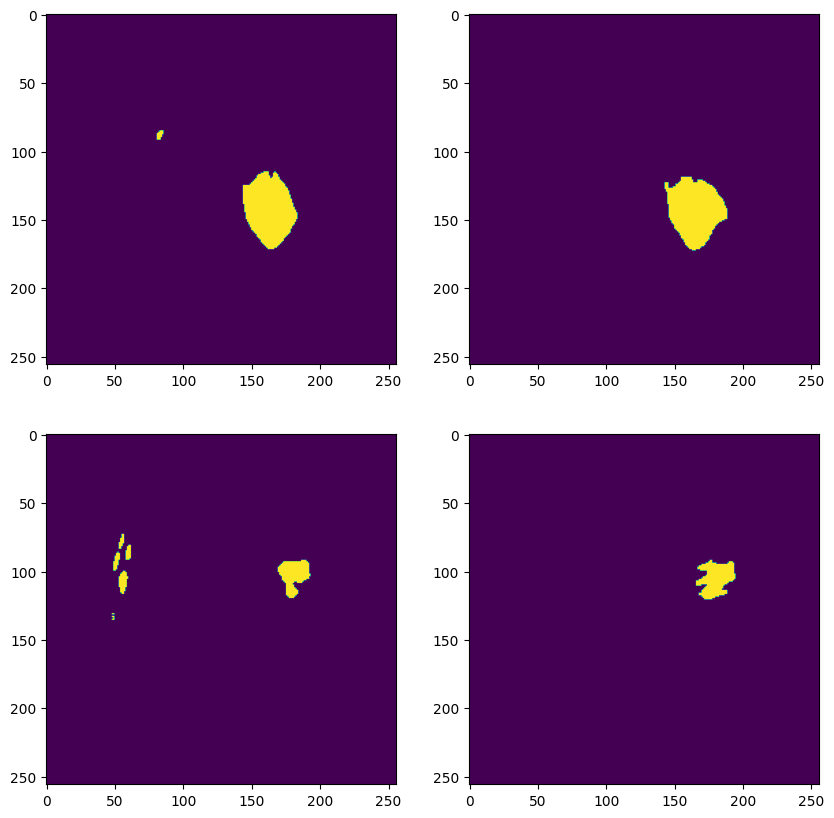

In [111]:
# model.load_weights('/kaggle/working/unet_model.keras')
a = 0
for x in val_dataset:
    a +=1
    if a == 4:
        break
    image, mask = x[0], x[1]
    print(image.shape)
    pred = model(image)
    plt.subplots(2, 2, figsize=(10, 10))

    for i in range(2):
        plt.subplot(2, 2, i*2+1)
        plt.imshow(pred[i] > 0.5)
        plt.subplot(2, 2, i*2+2)
        plt.imshow(mask[i])
    plt.show()
